## Utilitaires Collab

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from google.colab import files
files.upload()

# From the subject
link : https://davidbert.github.io/AIF2024/xai/project.html
## Installation du client PROCGEN

In [1]:
!pip install procgen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.7/267.7 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: imageio-ffmpeg
    Found existing installation: imageio-ffmpeg 0.4.9
    Uninstalling imageio-ffmpeg-0.4.9:
      Successfully uninstalled imageio-ffmpeg-0.4.9


### This code assumes that "agent.py", "procgen_wrappers.py" and "agent_weights.pth" are copies inside collab file "/content"

In [2]:
import torch
from procgen import ProcgenEnv
from procgen_wrappers import VecExtractDictObs, TransposeFrame, ScaledFloatFrame
import imageio
from IPython.display import Image
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import torchvision.transforms as transforms
import torch.nn.functional as F


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Instanciation of the environment

In [4]:
env = ProcgenEnv(
        num_envs=1,
        env_name="fruitbot",
        start_level=0,
        num_levels=100,
        distribution_mode='easy',
    )

env = VecExtractDictObs(env, "rgb")
env = TransposeFrame(env)
env = ScaledFloatFrame(env)

The Agent class is defined in the agent.py file.
An agent is composed of a feature extractor and a policy. The feature extractor is a neural network that takes the image as input and outputs a vector of features. The policy is a neural network that takes the features as input and outputs a score for each action. The action with the highest score is the one that is chosen.

You can use it as follows:

In [5]:
from agent import Agent
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device=torch.device('cpu')
agent = Agent()
agent.load_state_dict(torch.load('agent_weights.pth', map_location=device))
agent.eval()

Agent(
  (features): ImpalaModel(
    (block1): ImpalaBlock(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (res1): ResidualBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (res2): ResidualBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (block2): ImpalaBlock(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (res1): ResidualBlock(
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(32, 32, kernel_size=(

The following code shows how to use the agent to play a game

In [6]:
obs = env.reset()

while True:
    obs = torch.FloatTensor(obs).to(device)
    action = agent(obs).argmax(1).cpu().numpy()
    obs, _, done ,_ = env.step(action)
    if done[0]:
        break

env.close()

## Code to record a gif


/usr/local/lib/python3.10/dist-packages/imageio/plugins/pillow.py:390: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(


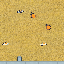

In [7]:

def obs_to_image(obs):
  return (obs[0].transpose(1,2,0) * 255).astype(np.uint8)

def display_trajectory(frames, fps=25):
  imageio.mimwrite('./tmp.gif',
                [obs_to_image(frame) for i, frame in enumerate(frames)],
                fps=fps)
  return(Image(open('tmp.gif','rb').read(), width=500, height=500))

frames = []
obs = env.reset()

while True:
    frames.append(obs)
    #obs = torch.FloatTensor(obs).to('cuda')   #code déjà dans la focntion "play"
    #action = agent(obs).argmax(1).cpu().numpy()   #code déjà dans la focntion "play"
    obs, _, done ,_ = env.step(action)
    img = env.render()
    if done[0]:
        break

env.close()

display_trajectory(frames)

## Objectives
You can use the tools seen in the course, and you can also use other tools if you want. **You are expected to produce three types of explanations.**
*Don't be surprised if some methods don't work well on every frame (like grad-CAM), it is normal.*

# Student Part

Les images d'explicabilité sont générées dans les boucles while.  
Afin de simplifier l'interprétation des résultats, des vues combinées sont générées, avec le gif de la séquence de jeu à gauche et la vue interprétée à droite.   
Les gif ainsi générés sont disponibles

*   en affichage, dans la cellule "output"
*   dans le dossier 'content' de l'instance 'Colab'.

Les fonctions "obs_to_image" et de transformtation en tenseurs sont rappelées dans les en-têtes de partie, pour assurer l'indépendance de celles-ci.





## LIME

In [8]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=b1920ddfbf892df2ac354a66eb21bbe8bd1da772679f7cca800bd845f4ec53c8
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [42]:
means, stds = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
agent.to(device)
lime_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(means, stds),
    ])

def batch_predict(images):
  with torch.no_grad():
    agent.eval()
    batch = torch.stack(tuple(lime_transform(i) for i in images), dim=0)

    batch = batch.to(device)
    logits = agent(batch)
  return logits.detach().cpu().numpy()

In [43]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import logging

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/imageio/plugins/pillow.py:390: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(


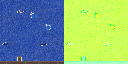

In [44]:
explainer = lime_image.LimeImageExplainer()

composite_frames = []

for frame in frames:
    rgb_frame = obs_to_image(frame)
    # generation de la vue interpretee
    explanation = explainer.explain_instance(rgb_frame,
                                            batch_predict,
                                            top_labels=5,
                                            hide_color=0,
                                            num_samples=1000)


    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                positive_only=False,
                                                num_features=10,
                                                hide_rest=False)

    img_boundry = mark_boundaries(temp / 255.0, mask)
    # generation de la vue composee
    composite_image = np.hstack((rgb_frame, img_boundry))
    composite_frames.append(composite_image)



def display_trajectory(frames, fps=25):
    converted_frames = [(frame * 255).astype(np.uint8) if frame.dtype == np.float64 else frame for frame in frames]

    imageio.mimwrite('./lime.gif', converted_frames, fps=fps)
    return Image(open('lime.gif', 'rb').read(), width=500, height=500)
# le GIF est disponible dans le dossier ('/content') de l'environnement d'exécution

display_trajectory(composite_frames, fps=25)


## Vanilla gradient back-propagation

In [46]:
agent.to('cuda').eval()

means, stds = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

def obs_to_image(obs):
    return (obs[0].transpose(1, 2, 0) * 255).astype(np.uint8)

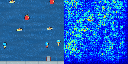

In [47]:
composite_frames = []
obs = env.reset()

while True:
    # Convertit en RGB et demande le gardient
    rgb_frame = obs_to_image(obs)
    obs_tensor = transform(rgb_frame).unsqueeze(0).to('cuda')
    obs_tensor.requires_grad_()

    # Passes forward et backward
    pred = agent(obs_tensor)
    pred_idx = pred.argmax(1)
    agent.zero_grad()
    pred[0, pred_idx].backward()

    # Génération des saliency maps puis normalisation de celles-ci
    saliency, _ = torch.max(obs_tensor.grad.data.abs(), dim=1)
    saliency = saliency.squeeze().cpu()
    min_val = torch.min(saliency).item()
    max_val = torch.max(saliency).item()
    saliency_normalized = (saliency.numpy() - min_val) / (max_val - min_val)

    # Application d'un jeu de couleurs sur les saliency map
    saliency_colored = cm.jet(saliency_normalized)[:, :, :3]
    saliency_colored = (saliency_colored * 255).astype(np.uint8)

    # Création et stockage des images composites
    composite_image = np.hstack((rgb_frame, saliency_colored))
    composite_frames.append(composite_image)

    # Projection sur l'action suivante
    action = pred.argmax(1).cpu().numpy()
    obs, _, done, _ = env.step(action)

    if done:
        break

env.close()

# Enregistrement de GIF, nommé selon la méthode
def display_trajectory(frames, fps=25):
    imageio.mimwrite('./vanilla_trajectory.gif', frames, fps=fps)
    return Image(open('vanilla_trajectory.gif', 'rb').read(), width=500, height=500)
# le GIF est disponible dans le dossier ('/content') de l'environnement d'exécution

display_trajectory(composite_frames, fps=25)


## Smooth grad


In [49]:
def obs_to_image(obs):
    return (obs[0].transpose(1, 2, 0) * 255).astype(np.uint8)

In [50]:
agent = Agent().to('cuda')
means, stds = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

In [51]:
"""Ajout de bruit aléatoire à l'image."""
def add_random_noise(image, noise_level=0.15):
    return image + noise_level * torch.randn_like(image)

In [52]:
def get_vanilla_grad(img, model):
    if not img.requires_grad:
        img.requires_grad_(True)
    output = model(img)
    output_idx = output.argmax()
    output_max = output[0, output_idx]
    model.zero_grad()
    output_max.backward()
    grad = img.grad if img.grad is not None else torch.zeros_like(img)
    img.grad = None  # Clear gradients after backward pass to avoid accumulation
    return grad

In [53]:
def calculate_smooth_grad(frame, model, num_samples=50, noise_level=0.15):
    grad_accum = 0
    for _ in range(num_samples):
        noisy_frame = add_random_noise(frame, noise_level)
        noisy_grad = get_vanilla_grad(noisy_frame, model)
        grad_accum += noisy_grad.data.abs()
    return grad_accum / num_samples

In [54]:
agent.eval()
saliency_maps = []
composite_frames = []
obs = env.reset()

while True:
    rgb_frame = obs_to_image(obs)
    frame_tensor = transform(rgb_frame).unsqueeze(0).cuda()

    # calcul du gradient par SmoothGrad
    smooth_grad = calculate_smooth_grad(frame_tensor, agent)

    # Génération des saliency maps, avec normalisation et ajout d'une palette de couleurs
    saliency = smooth_grad.squeeze(0).cpu().numpy()
    saliency_aggregated = np.mean(saliency, axis=0)
    saliency_normalized = (saliency_aggregated - np.min(saliency_aggregated)) / (np.max(saliency_aggregated) - np.min(saliency_aggregated))

    saliency_colored = cm.jet(saliency_normalized)
    saliency_colored = (saliency_colored * 255).astype(np.uint8)
    saliency_colored = saliency_colored[..., :3]  # Ensure it's RGB

    # Combine the original RGB frame with the colored saliency map
    composite_image = np.hstack((rgb_frame, saliency_colored))
    composite_frames.append(composite_image)


    pred = agent(frame_tensor)

    action = pred.argmax(1).cpu().numpy()
    obs, _, done, _ = env.step(action)

    if done:
        break

env.close()


In [55]:
def display_trajectory(frames, fps=25):
    converted_frames = [frame.astype(np.uint8) if frame.dtype != np.uint8 else frame for frame in frames]

    imageio.mimwrite('./smooth_tmp.gif',
                     converted_frames,  # Saving of a gif
                     fps=fps)
    return Image(open('smooth_tmp.gif', 'rb').read(), width=500, height=500)

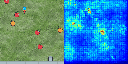

In [56]:
display_trajectory(composite_frames, fps=25)